### Import libraries and create DataFrame from csv 

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("FantasyPros_Fantasy_Football_Statistics_WR.csv")

df.head(10)

,Rank,Player,REC,TGT,YDS,Y/R,LG,20+,TD,ATT,YDS.1,TD.1,FL,G,FPTS,FPTS/G,ROST
0,1,Justin Jefferson (MIN),128.00,184.00,1809.00,14.10,64.00,49.00,8.00,4.00,24.00,1.00,-,17.0,368.60,21.70,99%
1,2,Tyreek Hill (MIA),119.00,170.00,1710.00,14.40,64.00,45.00,7.00,7.00,32.00,1.00,-,17.0,341.20,20.10,100%
2,3,Davante Adams (LV),100.00,180.00,1516.00,15.20,60.00,47.00,14.00,3.00,-1.00,-,-,17.0,335.50,19.70,100%
3,4,Stefon Diggs (BUF),110.00,156.00,1455.00,13.20,53.00,35.00,11.00,1.00,-3.00,-,-,17.0,321.20,18.90,100%
4,5,CeeDee Lamb (DAL),107.00,156.00,1359.00,12.70,39.00,30.00,9.00,10.00,47.00,-,-,17.0,301.60,17.70,100%
5,6,A.J. Brown (PHI),88.00,145.00,1496.00,17.00,78.00,45.00,11.00,-,-,-,2.00,17.0,299.60,17.60,100%
6,7,Amon-Ra St. Brown (DET),106.00,146.00,1161.00,11.00,49.00,15.00,6.00,9.00,95.00,-,-,16.0,267.60,16.70,100%
7,8,Jaylen Waddle (MIA),75.00,117.00,1356.00,18.10,84.00,41.00,8.00,3.00,26.00,-,1.00,17.0,259.20,15.20,100%
8,9,DeVonta Smith (PHI),95.00,136.00,1196.00,12.60,45.00,30.00,7.00,-,-,-,1.00,17.0,254.60,15.00,99%
9,10,Amari Cooper (CLE),78.00,132.00,1160.00,14.90,55.00,31.00,9.00,-,-,-,-,17.0,247.00,14.50,97%


### Remove irrelevant columns and define column numbers

In [72]:
df.drop(['FL', 'ROST'], axis=1, inplace=True)

# Enumerate the columns to view their positions (numbers) and names
list(enumerate(df.columns))

[(0, 'Rank'),
 (1, 'Player'),
 (2, 'REC'),
 (3, 'TGT'),
 (4, 'YDS'),
 (5, 'Y/R'),
 (6, 'LG'),
 (7, '20+'),
 (8, 'TD'),
 (9, 'ATT'),
 (10, 'YDS.1'),
 (11, 'TD.1'),
 (12, 'G'),
 (13, 'FPTS'),
 (14, 'FPTS/G')]

### Check the data types of the columns

In [73]:
df.dtypes

Rank        int64
Player     object
REC        object
TGT        object
YDS        object
Y/R        object
LG         object
20+        object
TD         object
ATT        object
YDS.1      object
TD.1       object
G         float64
FPTS       object
FPTS/G     object
dtype: object

### Convert columns with an 'object' data type to a 'float' data type

In [74]:
# Convert columns with object data type, excluding certain columns
convert = df.select_dtypes('object').columns.difference(['Player'])
df[convert] = df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)

# Convert specific columns to desired data types
df['Rank'] = df['Rank'].astype('Int64')

# Verify the data types
df.dtypes

Rank        Int64
Player     object
REC       float64
TGT       float64
YDS       float64
Y/R       float64
LG        float64
20+       float64
TD        float64
ATT       float64
YDS.1     float64
TD.1      float64
G         float64
FPTS      float64
FPTS/G    float64
dtype: object

### Verify data conversion is correct

In [75]:
df.head(10)

,Rank,Player,REC,TGT,YDS,Y/R,LG,20+,TD,ATT,YDS.1,TD.1,G,FPTS,FPTS/G
0,1,Justin Jefferson (MIN),128.0,184.0,1809.0,14.1,64.0,49.0,8.0,4.0,24.0,1.0,17.0,368.6,21.7
1,2,Tyreek Hill (MIA),119.0,170.0,1710.0,14.4,64.0,45.0,7.0,7.0,32.0,1.0,17.0,341.2,20.1
2,3,Davante Adams (LV),100.0,180.0,1516.0,15.2,60.0,47.0,14.0,3.0,-1.0,0.0,17.0,335.5,19.7
3,4,Stefon Diggs (BUF),110.0,156.0,1455.0,13.2,53.0,35.0,11.0,1.0,-3.0,0.0,17.0,321.2,18.9
4,5,CeeDee Lamb (DAL),107.0,156.0,1359.0,12.7,39.0,30.0,9.0,10.0,47.0,0.0,17.0,301.6,17.7
5,6,A.J. Brown (PHI),88.0,145.0,1496.0,17.0,78.0,45.0,11.0,0.0,0.0,0.0,17.0,299.6,17.6
6,7,Amon-Ra St. Brown (DET),106.0,146.0,1161.0,11.0,49.0,15.0,6.0,9.0,95.0,0.0,16.0,267.6,16.7
7,8,Jaylen Waddle (MIA),75.0,117.0,1356.0,18.1,84.0,41.0,8.0,3.0,26.0,0.0,17.0,259.2,15.2
8,9,DeVonta Smith (PHI),95.0,136.0,1196.0,12.6,45.0,30.0,7.0,0.0,0.0,0.0,17.0,254.6,15.0
9,10,Amari Cooper (CLE),78.0,132.0,1160.0,14.9,55.0,31.0,9.0,0.0,0.0,0.0,17.0,247.0,14.5


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [76]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/R', 'LG', 'G', 'FPTS', 'FPTS/G']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/R,LG,G,FPTS,FPTS/G,REC/game,TGT/game,YDS/game,20+/game,TD/game,ATT/game,YDS.1/game,TD.1/game
0,1,Justin Jefferson (MIN),14.1,64.0,17.0,368.6,21.7,7.5,10.8,106.4,2.9,0.5,0.2,1.4,0.1
1,2,Tyreek Hill (MIA),14.4,64.0,17.0,341.2,20.1,7.0,10.0,100.6,2.6,0.4,0.4,1.9,0.1
2,3,Davante Adams (LV),15.2,60.0,17.0,335.5,19.7,5.9,10.6,89.2,2.8,0.8,0.2,-0.1,0.0
3,4,Stefon Diggs (BUF),13.2,53.0,17.0,321.2,18.9,6.5,9.2,85.6,2.1,0.6,0.1,-0.2,0.0
4,5,CeeDee Lamb (DAL),12.7,39.0,17.0,301.6,17.7,6.3,9.2,79.9,1.8,0.5,0.6,2.8,0.0
5,6,A.J. Brown (PHI),17.0,78.0,17.0,299.6,17.6,5.2,8.5,88.0,2.6,0.6,0.0,0.0,0.0
6,7,Amon-Ra St. Brown (DET),11.0,49.0,16.0,267.6,16.7,6.6,9.1,72.6,0.9,0.4,0.6,5.9,0.0
7,8,Jaylen Waddle (MIA),18.1,84.0,17.0,259.2,15.2,4.4,6.9,79.8,2.4,0.5,0.2,1.5,0.0
8,9,DeVonta Smith (PHI),12.6,45.0,17.0,254.6,15.0,5.6,8.0,70.4,1.8,0.4,0.0,0.0,0.0
9,10,Amari Cooper (CLE),14.9,55.0,17.0,247.0,14.5,4.6,7.8,68.2,1.8,0.5,0.0,0.0,0.0


### Calculate the correlations for the final stats across different conditions

In [77]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/R,0.32,0.09,0.22,-0.01,0.15
LG,0.68,0.59,0.26,0.32,0.46
REC/game,0.97,0.97,0.87,0.83,0.91
TGT/game,0.96,0.96,0.86,0.83,0.90
YDS/game,0.98,0.98,0.95,0.92,0.96
20+/game,0.84,0.81,0.71,0.56,0.73
TD/game,0.80,0.85,0.70,0.63,0.75
ATT/game,0.21,0.20,0.03,0.38,0.20
YDS.1/game,0.18,0.12,0.00,0.25,0.14
TD.1/game,0.22,0.20,0.19,0.71,0.33


### Assign the weights for the final stats

In [78]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/R,0.15,0.02,1.00
LG,0.46,0.21,1.00
REC/game,0.91,0.82,1.82
TGT/game,0.90,0.82,1.82
YDS/game,0.96,0.92,1.92
20+/game,0.73,0.53,1.53
TD/game,0.75,0.56,1.56
ATT/game,0.20,0.04,1.00
YDS.1/game,0.14,0.02,1.00
TD.1/game,0.33,0.11,1.00


### Multiply the assigned weights to the final stats

In [79]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df[['Rank', 'Player', 'FPTS/G'] + weight_columns].head(10)

,Rank,Player,FPTS/G,Y/R_weighted,LG_weighted,REC/game_weighted,TGT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,ATT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
0,1,Justin Jefferson (MIN),21.7,14.1,64.0,13.7,19.6,204.1,4.4,0.8,0.2,1.4,0.1
1,2,Tyreek Hill (MIA),20.1,14.4,64.0,12.8,18.2,192.9,4.0,0.6,0.4,1.9,0.1
2,3,Davante Adams (LV),19.7,15.2,60.0,10.8,19.2,171.1,4.3,1.2,0.2,-0.1,0.0
3,4,Stefon Diggs (BUF),18.9,13.2,53.0,11.9,16.7,164.2,3.2,0.9,0.1,-0.2,0.0
4,5,CeeDee Lamb (DAL),17.7,12.7,39.0,11.5,16.7,153.2,2.8,0.8,0.6,2.8,0.0
5,6,A.J. Brown (PHI),17.6,17.0,78.0,9.5,15.4,168.8,4.0,0.9,0.0,0.0,0.0
6,7,Amon-Ra St. Brown (DET),16.7,11.0,49.0,12.0,16.5,139.2,1.4,0.6,0.6,5.9,0.0
7,8,Jaylen Waddle (MIA),15.2,18.1,84.0,8.0,12.5,153.0,3.7,0.8,0.2,1.5,0.0
8,9,DeVonta Smith (PHI),15.0,12.6,45.0,10.2,14.5,135.0,2.8,0.6,0.0,0.0,0.0
9,10,Amari Cooper (CLE),14.5,14.9,55.0,8.4,14.2,130.8,2.8,0.8,0.0,0.0,0.0


### Display the columns potentially to be included in the average weighted score

In [80]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['REC/game_weighted',
 'TGT/game_weighted',
 'YDS/game_weighted',
 '20+/game_weighted',
 'TD/game_weighted',
 'FPTS/G']

### Define the columns to be used for the average weighted score

In [81]:
# Define select columns to be used for the average weighted score
avg = ['REC/game_weighted',
 'TGT/game_weighted',
 'YDS/game_weighted',
 '20+/game_weighted',
 'TD/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [82]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [83]:
# Display the results for the select columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance']]
analysis.set_index('Rank', inplace=True)
analysis.sort_values(by='Final Rank', ascending=True).head(30)

,Final Rank,Player,Score,Variance
Rank,,,,
1,1,Justin Jefferson (MIN),44.1,0
2,2,Tyreek Hill (MIA),41.4,0
23,3,Cooper Kupp (LAR),39.1,20
3,4,Davante Adams (LV),37.7,-1
4,5,Stefon Diggs (BUF),36.0,-1
6,6,A.J. Brown (PHI),36.0,0
11,7,Ja'Marr Chase (CIN),34.6,4
47,8,DeAndre Hopkins (TEN),34.0,39
5,9,CeeDee Lamb (DAL),33.8,-4


### Compare per-game stats of two players and visualize the results

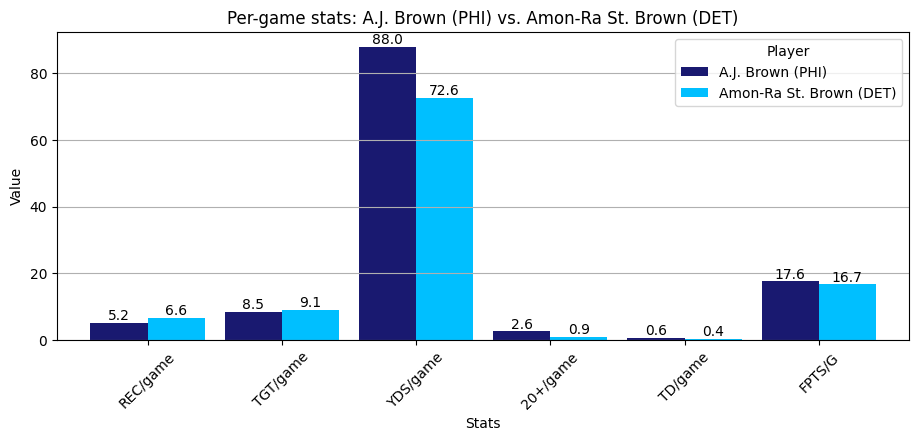

,Final Rank,Y/R,LG,G,FPTS,FPTS/G,REC/game,TGT/game,YDS/game,20+/game,TD/game,ATT/game,YDS.1/game,TD.1/game
Player,,,,,,,,,,,,,,
A.J. Brown (PHI),6,17.0,78.0,17.0,299.6,17.6,5.2,8.5,88.0,2.6,0.6,0.0,0.0,0.0
Amon-Ra St. Brown (DET),13,11.0,49.0,16.0,267.6,16.7,6.6,9.1,72.6,0.9,0.4,0.6,5.9,0.0


In [84]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats: {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]